In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

47

(32, 256, 256, 3)
[2 0 2 1 2 1 0 0 0 0 0 1 1 0 2 0 2 2 1 2 2 0 1 2 1 1 2 1 1 1 0 1]


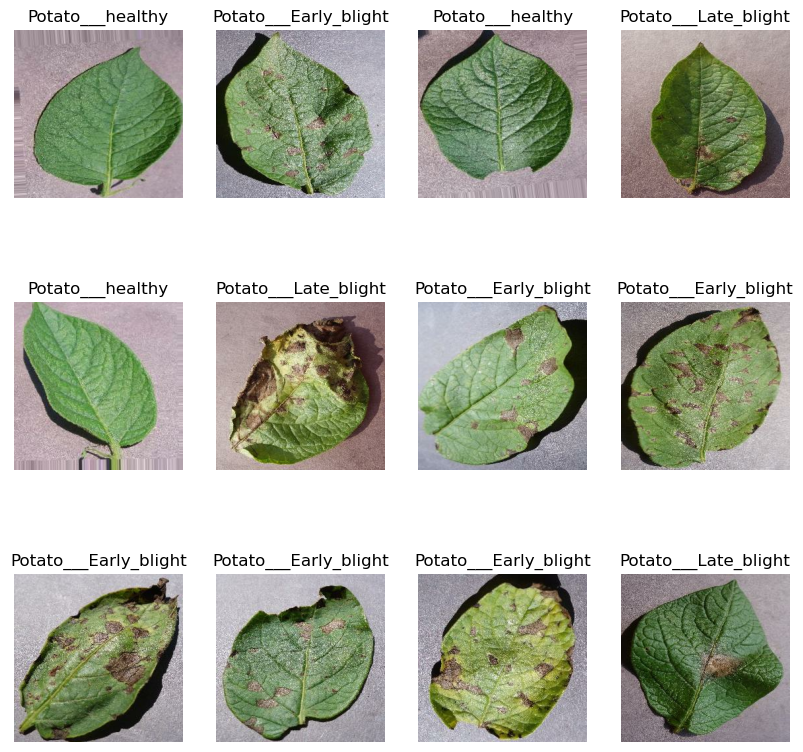

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
37/37 [==============================] - 45s 1s/step - loss: 1.0607 - accuracy: 0.4000 - val_loss: 0.8380 - val_accuracy: 0.6328
Epoch 2/20
37/37 [==============================] - 47s 1s/step - loss: 0.5851 - accuracy: 0.7246 - val_loss: 0.3838 - val_accuracy: 0.8672
Epoch 3/20
37/37 [==============================] - 45s 1s/step - loss: 0.4511 - accuracy: 0.8008 - val_loss: 0.2815 - val_accuracy: 0.8750
Epoch 4/20
37/37 [==============================] - 46s 1s/step - loss: 0.3220 - accuracy: 0.8686 - val_loss: 0.2010 - val_accuracy: 0.9453
Epoch 5/20
37/37 [==============================] - 46s 1s/step - loss: 0.2603 - accuracy: 0.9059 - val_loss: 0.3051 - val_accuracy: 0.8906
Epoch 6/20
37/37 [==============================] - 46s 1s/step - loss: 0.3344 - accuracy: 0.8686 - val_loss: 0.4070 - val_accuracy: 0.8359
Epoch 7/20
37/37 [==============================] - 46s 1s/step - loss: 0.3578 - accuracy: 0.8669 - val_loss: 0.1956 - val_accuracy: 0.9141
Epoch 8/20
37/37 [==

In [13]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 233ms/step - loss: 0.1680 - accuracy: 0.9323


[0.16803063452243805, 0.9322916865348816]

In [14]:
history.history['loss']

[1.0607309341430664,
 0.5851474404335022,
 0.45107540488243103,
 0.321983277797699,
 0.2603423297405243,
 0.33440113067626953,
 0.3578234910964966,
 0.2417486608028412,
 0.2370436042547226,
 0.22661153972148895,
 0.29366573691368103,
 0.22467726469039917,
 0.1634652465581894,
 0.18615268170833588,
 0.1299750953912735,
 0.13772065937519073,
 0.19095966219902039,
 0.11955586075782776,
 0.10179447382688522,
 0.13044311106204987]

In [15]:
history.history['accuracy']

[0.4000000059604645,
 0.7245762944221497,
 0.8008474707603455,
 0.8686440587043762,
 0.9059321880340576,
 0.8686440587043762,
 0.8669491410255432,
 0.9076271057128906,
 0.9050847291946411,
 0.9245762825012207,
 0.8855932354927063,
 0.9050847291946411,
 0.9364407062530518,
 0.9305084943771362,
 0.944915235042572,
 0.9457626938819885,
 0.9279661178588867,
 0.9618644118309021,
 0.9635593295097351,
 0.9584745764732361]

In [16]:
history.history['val_loss']

[0.8379758596420288,
 0.3838396668434143,
 0.28151935338974,
 0.20100493729114532,
 0.3051396906375885,
 0.40701934695243835,
 0.19564619660377502,
 0.2639099955558777,
 0.21549667418003082,
 0.33215564489364624,
 0.15084314346313477,
 0.130881667137146,
 0.16976070404052734,
 0.14087986946105957,
 0.14951395988464355,
 0.16536062955856323,
 0.09655443578958511,
 0.06529609113931656,
 0.11326472461223602,
 0.14085260033607483]

In [17]:
history.history['val_accuracy']

[0.6328125,
 0.8671875,
 0.875,
 0.9453125,
 0.890625,
 0.8359375,
 0.9140625,
 0.8984375,
 0.9453125,
 0.90625,
 0.9453125,
 0.9453125,
 0.9375,
 0.9609375,
 0.9453125,
 0.921875,
 0.9609375,
 0.96875,
 0.953125,
 0.9375]

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

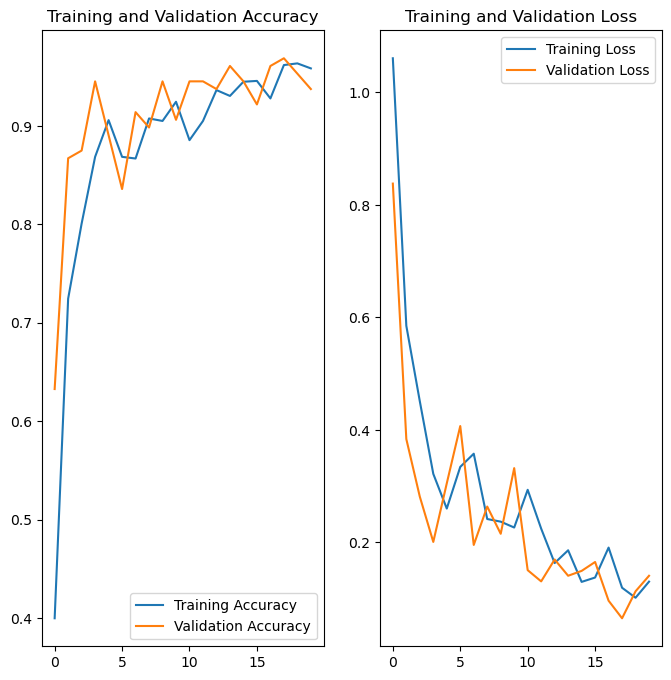

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [20]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 284ms/step


In [21]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


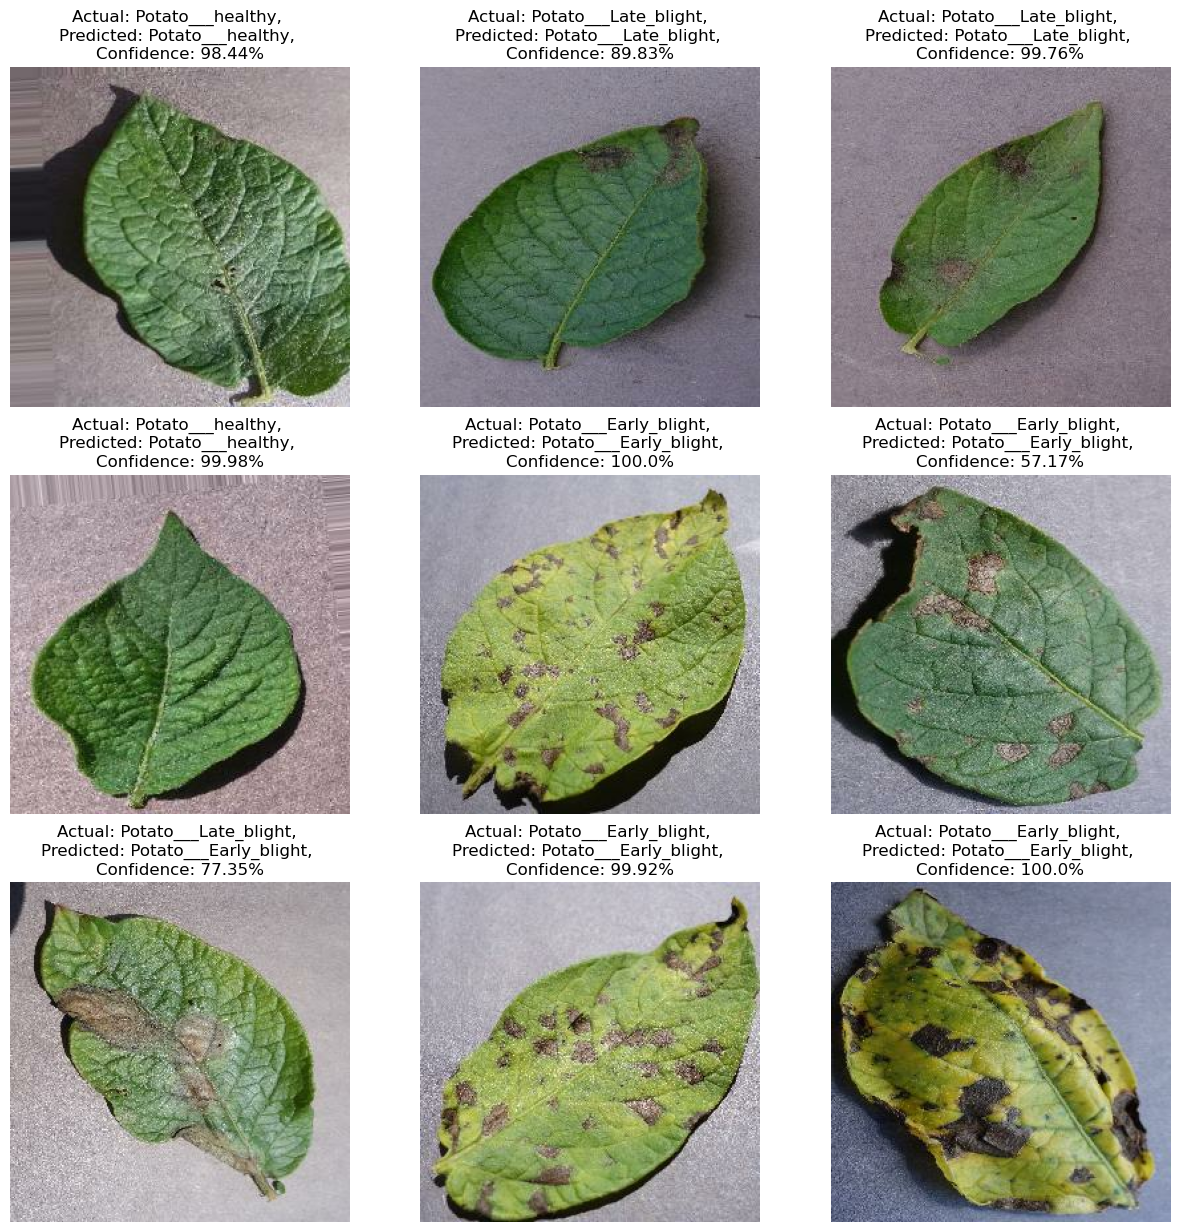

In [22]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [23]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        59
           1       0.93      0.86      0.90        66
           2       0.98      0.94      0.96        67

    accuracy                           0.93       192
   macro avg       0.93      0.93      0.93       192
weighted avg       0.94      0.93      0.93       192



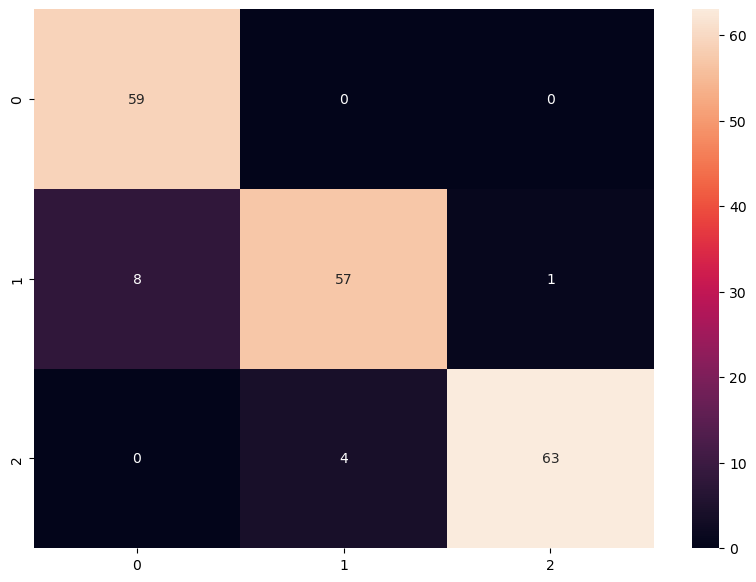

In [24]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [26]:
filename = "Model1-2-BatchSize32.joblib"
joblib.dump(model, filename)

['Model1-2-BatchSize32.joblib']